# HW 1. Логистическая регрессия

In [98]:
import os

import cv2
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Matplotlib is building the font cache; this may take a moment.


## Загрузка данных

Для того чтобы загрузить данные в нейросеть или более простые алгоритмы ML, их необходимо должным образом открыть и преобразовать в вектор с числами. Для этого воспользуемся функцией ```read_files()```.

Этот парсер делает следующие вещи:
 - открывает файл картинки с диска (с помощью библиотеки opencv),
 - проверяет, что картинка действительно открылась и сейчас является матрицей (```np.array```),
 - преобразует матрицу в вектор (путем записи всех столбцов друг под другом),
 - возвращает массив из векторов, в которых хранятся картинки, и лейбл, соответствующий каждой картинке.

In [40]:
def read_files(path: str, ans: int, target_dim: tuple = (256, 256)) -> dict[str, NDArray[np.float64]]:
    files = os.listdir(path)
    X = None
    for i, name in enumerate(files):
        img = cv2.imread(path + '/' + name, 0) # 0 means black-white picture
        if img.shape != 0:
            img = cv2.resize(img, target_dim, interpolation=cv2.INTER_LINEAR)
            vect = img.reshape(1, 256 ** 2) / 255.

            X = vect if (X is None) else np.vstack((X, vect))
    y = np.ones((len(files))) * ans
    return {"data": X, "labels": y}

In [10]:
?np.vstack

Signature:       np.vstack(tup, *, dtype=None, casting='same_kind')
Call signature:  np.vstack(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function vstack at 0x00000233EC2EBEC0>
File:            c:\users\marin\appdata\local\programs\python\python313\lib\site-packages\numpy\_core\shape_base.py
Docstring:      
Stack arrays in sequence vertically (row wise).

This is equivalent to concatenation along the first axis after 1-D arrays
of shape `(N,)` have been reshaped to `(1,N)`. Rebuilds arrays divided by
`vsplit`.

This function makes most sense for arrays with up to 3 dimensions. For
instance, for pixel-data with a height (first axis), width (second axis),
and r/g/b channels (third axis). The functions `concatenate`, `stack` and
`block` provide more general stacking and concatenation operations.

Parameters
----------
tup : sequence of ndarrays
    The arrays must have the same shape along all but the first axis.
    1-D arrays must have the same length.

Логика программы следующая:
 - есть класс ```LogisticRegression```. Он содержит веса модели и нужен для того, чтобы генерировать предсказания. Также, этот класс снабжен методом backward() для возможности дифференцирования функции потерь по весам этого класса.
 - есть класс ```Loss```. Он определяет функцию потерь, которую мы хотим использовать. Также, этот класс осуществляет подсчет градиентов функции потерь по всем весам модели.
 - есть класс ```Optimizer```. Он отвечает за то, как будут обновляться веса после подсчета градиентов (после работы класса ```Loss```). Сегодня мы рассматриваем простой градиентный спуск, но более сложные модели используют более усовершенствованные алгоритмы оптимизации.

То есть:
 1. Вызывается метод ```forward()``` нашей модели (логистической регрессии). После этого у нас выводятся текущие предсказания модели.
 2. Вызывается метод ```loss()```, который сравнивает предсказания модели с истинными ответами. После этого подсчитываются градиенты функции потерь по всем весам модели.
 3. Подсчитанные градиенты вычитаются из весов (происходит шаг градиентного спуска) путем вызова ```optimizer.step()```

## Логистическая регрессия. Backward propagation
Back propagation реализуется с помощью уравнений, написанных ниже. Для подсчитанной функции потерь:
$$
\mathcal{L} = -\frac{1}{m} \sum_{i=1}^{m} y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)
$$
где $\hat{y}_i = \sigma(w^T x_i + b)$, где $\sigma$ - сигмоидная функция.

### calculations
Формуля для $\mathcal{L(y,\hat{y}) = L(y, \{w_i\} , \{x_i\}, b)}$ указана для набора исходов. Найдём градиент функции потерь для одного исхода.
$$
\mathcal{L(\hat{y}) = L(\{w_i\} , b)} = - y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})
$$
$$
-\frac{\mathcal{d}}{\mathcal{d}\hat{y}} \mathcal{L} = \frac{y}{\hat{y}} - \frac{1-y}{1-\hat{y}} 
$$
$$
\frac{\mathcal{d}}{\mathcal{d}z} \hat{y} = \frac{\mathcal{d}}{\mathcal{d}z} \sigma(z) = (1 + e^{-z})^{-2} * e^{-z} = \sigma^2(\frac{1}{\sigma} - 1) = \sigma(1-\sigma)
$$
$$
z = w^T x + b; \frac{\mathcal{d}}{\mathcal{d}w_i} z = x_i; \frac{\mathcal{d}}{\mathcal{d}b} z = 1.
$$
Градиент функции потерь для одного исходы ищится по следующим формулам:
$$
\frac{\mathcal{d}}{\mathcal{d}w_i} \mathcal{L} = \frac{dz}{dw_i}\frac{d\hat{y}}{dz}\frac{d\mathcal{L}}{d\hat{y}}= -\frac{dz}{dw_i}(y-\hat{y})= x_i(\hat{y}-y)
$$
$$
\frac{\mathcal{d}}{\mathcal{d}b} \mathcal{L} = \frac{dz}{db}\frac{d\hat{y}}{dz}\frac{d\mathcal{L}}{d\hat{y}}= -\frac{dz}{db}(y-\hat{y}) = (\hat{y}-y)
$$
Обобщим полученный результат для m исходов:
$$
\frac{\mathcal{d}}{\mathcal{d}\vec{w}} \mathcal{L} = \frac{1}{m} \sum_{k=1}^{m} \vec{x_k}(\hat{y}_k-y_k)
$$
$$
\frac{\mathcal{d}}{\mathcal{d}b} \mathcal{L} = \frac{1}{m} \sum_{k=1}^{m} (\hat{y}_k-y_k)
$$

In [209]:
class LogisticRegression:
    def __init__(self, n_features):
        """Initialize model parameters with zeros."""
        #self.w = np.random.rand(n_features)
        #self.b = 0.9
        self.w = np.zeros(n_features)
        self.b = 0


    def forward(self, X: NDArray[np.float64]):
        """Compute model predictions a.k.a. forward pass.
        Args:
            X: input data.
        Returns:
            probability predictions.
        """
        z = np.dot(X, self.w) + self.b
        return self.sigmoid(z)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

class Loss:
    def __init__(self):
        pass

    def __call__(self, y_pred, y_true):
        eps= 1e-15  # Малое значение для предотвращения ошибок логарифма
        y_pred = np.clip(y_pred, eps, 1 - eps)  # Ограничение значений
        loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return np.mean(loss)

    def backward(self, y_pred, y, X):
        m = len(y)
        dy = y_pred - y
        dw = X.T @ dy / m
        db = np.mean(dy)
        return dw, db

class Optimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def step(self, model, dw, db):
        model.w -= self.learning_rate * dw
        model.b -= self.learning_rate * db

## Задание

1. Загрузить датасет, разбить его на два датасета: первый для обучения, второй - для проверки качества (см. функцию [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) **(1 балл)**

In [190]:
dataset_path = "dataset/"
dataset_path_box = dataset_path + "box/"
dataset_path_nobox = dataset_path + "no_box/"

dataset_box = read_files(dataset_path_box, 1)
dataset_nobox = read_files(dataset_path_nobox, 0)
dataset = {
    "data" : np.concatenate((dataset_box["data"], dataset_nobox["data"])),
    "labels" :  np.concatenate((dataset_box["labels"], dataset_nobox["labels"]))
}
dataset_train_data, dataset_test_data, dataset_train_labels, dataset_test_labels = train_test_split(dataset["data"], dataset["labels"], random_state=42)

2. Посчитать производные функции потерь по $w$ и по $b$ **(3 балла)**  
**[[Посчитано тут](#calculations)]**


3. Реализовать цикл обучения, обновляя параметры логистической регрессии. Необходим график зависимости от номера итерации **(5 баллов)**:
$$w = w - \alpha \cdot \frac{\partial L}{\partial w}$$
<!-- <br> -->
$$b = b - \alpha \cdot \frac{\partial L}{\partial b}$$
Обратите внимание на величину $\alpha$. Ее надо подобрать, иначе алгоритм не будет обучаться.


0.0062587802543369415


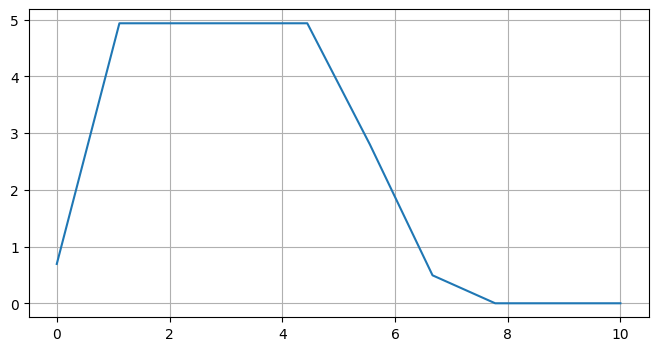

In [210]:
model = LogisticRegression(256**2)
loss = Loss()
optimizer = Optimizer(0.1)

MAX_ITER = 10
loss_array = np.zeros(MAX_ITER)

for i in range(MAX_ITER):
    model_prediction = model.forward(dataset_train_data)
    loss_array[i] = loss(model_prediction, dataset_train_labels)
    dw, db = loss.backward(model_prediction, dataset_train_labels, dataset_train_data)
    optimizer.step(model, dw, db)

print(np.average(np.abs(model.w)))

plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, MAX_ITER, MAX_ITER), loss_array)
plt.grid(True)
plt.show()

4. Посчитать качество модели по метрике [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) **(1 балл)**

In [197]:
model_prediction = np.where(model.forward(dataset_test_data)> 0.5, 1, 0)
print(accuracy_score(dataset_test_labels, model_prediction))

0.8


5. (бонус - оценивается только при успешном выполнении предыдущих пунктов) осуществить перебор по $\alpha$ и найти его оптимальное значение (обеспечивающее максимальную метрику accuracy при достаточно небольшом количестве итераций обучения) **(2 балла)**